true: 6, pred: 6


/home/konrad/miniconda3/envs/sanity_checks_pytorch/lib/python3.9/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448255797/work/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


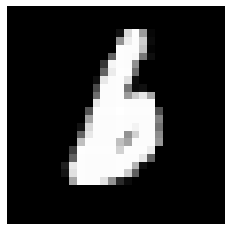

true: 8, pred: 8


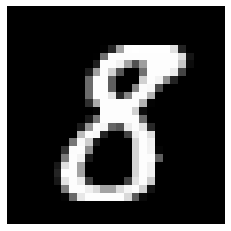

true: 1, pred: 1


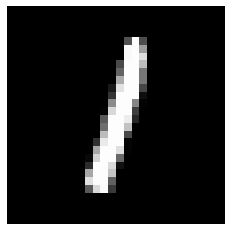

true: 6, pred: 6


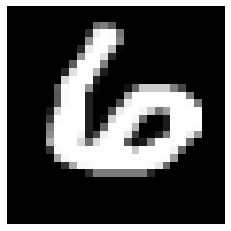

true: 1, pred: 1


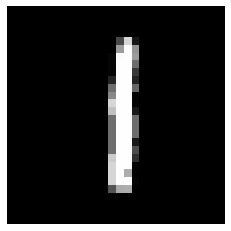

true: 4, pred: 4


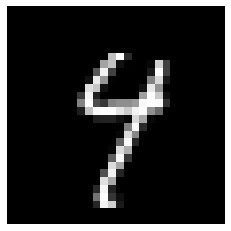

true: 8, pred: 8


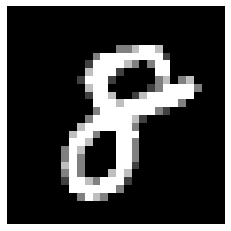

true: 0, pred: 0


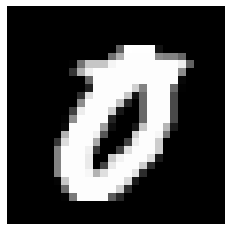

true: 6, pred: 6


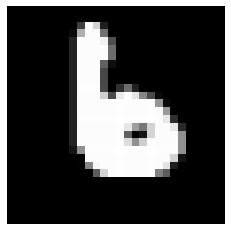

true: 7, pred: 7


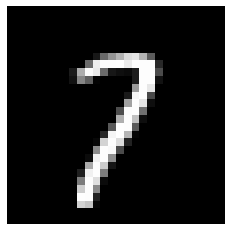

In [1]:
from torchvision import datasets, transforms
import copy
import torch
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from src import util

model = torch.load('models/cnn_mnist.pt', map_location=torch.device('cpu'))
model.eval()

transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])

dataset = datasets.MNIST('data', train=False, transform=transform)
dataset_subset = torch.utils.data.Subset(dataset, np.random.choice(len(dataset), 10, replace=False))
test_loader = torch.utils.data.DataLoader(dataset_subset, batch_size=1, shuffle=False)

single_instance = torch.utils.data.Subset(dataset, np.random.choice(len(dataset), 2, replace=False))
single_loader = torch.utils.data.DataLoader(single_instance, batch_size=1, shuffle=False)

for image, label in test_loader:
    pred = model(image).argmax(axis=1)
    npimg = np.squeeze(np.squeeze(image.numpy()))
    plt.imshow(npimg, cmap='gray')
    print(f'true: {label[0]}, pred: {pred[0]}')
    plt.axis('off')
    plt.show()

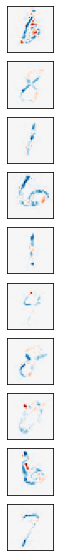

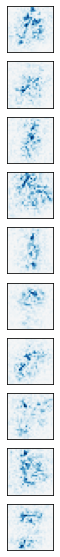

In [53]:
# visualize integrated gradients for mnist cnn

import torchvision
from captum.attr import IntegratedGradients, Saliency
from captum.attr import visualization as viz

def attribute_image_features(algorithm, input, label, **kwargs):
    model.zero_grad()
    tensor_attributions = algorithm.attribute(input, target=label, **kwargs)
    
    return tensor_attributions


# Given a NN model, ...
def visualize_saliency_method(model, saliency_class, saliency_kwargs, image, label, plt_fig_axis):
    image.requires_grad = True
    attrs = attribute_image_features(
            saliency_class(model), # get an instance of the saliency model class
            image,
            label=label,
            **saliency_kwargs
#             baselines=image * 0,
    )
    attrs = np.transpose(attrs.squeeze(0).cpu().detach().numpy(), (1,2,0))
#     print('Approximation delta: ', abs(delta))
    original_image = np.transpose(image.squeeze(0).cpu().detach().numpy(), (1, 2, 0))
    return viz.visualize_image_attr(attrs, original_image, method="heat_map",sign="all",
                          plt_fig_axis=plt_fig_axis, cmap="RdBu", show_colorbar=False,
                          use_pyplot=False)


ig = IntegratedGradients
fig, axs = plt.subplots(nrows=len(test_loader), ncols=1, figsize=(10, 10))
for (image, label), row in zip(test_loader, range(len(test_loader))):
    ig_kwargs = {'baselines': image * 0} # stuff specific to integrated gradients
    fig, _ = visualize_saliency_method(model, ig, ig_kwargs, image, label, (fig, axs[row]))
plt.show(fig)

sal = Saliency
fig, axs = plt.subplots(nrows=len(test_loader), ncols=1, figsize=(10, 10))
for (image, label), row in zip(test_loader, range(len(test_loader))):
    sal_kwargs = {} # stuff specific to gradients (saliency)
    fig, _ = visualize_saliency_method(model, sal, sal_kwargs, image, label, (fig, axs[row]))
plt.show(fig)

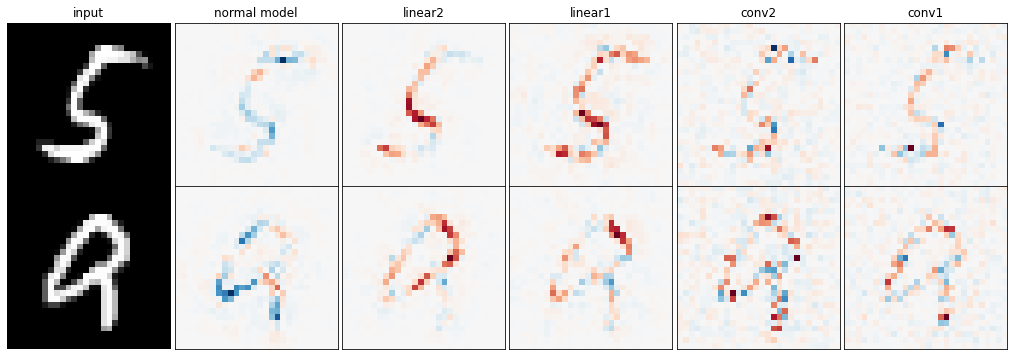

In [40]:
module_paths = [['linear2'], ['linear1'], ['conv2'], ['conv1']]
model_copy = copy.deepcopy(model)

def visualize_cascading_randomization(model, module_paths, examples, saliency_method):
    # make plt plot
    nrows = len(examples)
    ncols = len(module_paths) + 2
    fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(3*ncols, 3*nrows))
    fig.subplots_adjust(hspace=0, wspace=0)
    
    # show input image at the very left
    for (image, _), row in zip(examples, range(nrows)):
        npimg = np.squeeze(np.squeeze(image.numpy()))
        axs[row, 0].imshow(npimg, cmap='gray')
        axs[row, 0].axis('off')
    
    # show visualizations before scrambling the model
    for (image, label), row in zip(examples, range(nrows)):
        pred = model(image).argmax(axis=1).item()
        # TODO set sal_kwargs depending on which saliency method is given?
        fig, _ = visualize_saliency_method(model, sal_method, sal_kwargs, image, label, (fig, axs[row, 1]))

    # cascading randomization and visualization of IG
    # start with 1 because 0th column is unscrambled model
    for path, col in zip(module_paths, range(2, ncols)):
        util.rand_layers(model, [path])
        for (image, label), row in zip(examples, range(nrows)):
            pred = model(image).argmax(axis=1).item()
            # TODO set sal_kwargs depending on which saliency method is given?
            fig, _ = visualize_saliency_method(model, sal_method, sal_kwargs, image, label, (fig, axs[row, col]))
    
    col_titles = ['input', 'normal model'] + [x for x in map((lambda x: '_'.join(x)), module_paths)]
    for ax, col in zip(axs[0], col_titles):
        ax.set_title(col)

visualize_cascading_randomization(model_copy, module_paths, single_loader)

In [47]:
ig = IntegratedGradients
ig(model)